## Laboratorio 3 - Clasificación

## Paula Hípola Gómez, José Ignacio Navas Sanz y Belén Ortega Pérez

## Entregable 3 - Clasificador de Residuos

In [1]:
%config IPCompleter.greedy=True
%reset
#Importamos las librerías necesarias
#Numpy
import numpy as np
#Pandas
import pandas as pd
#Scikit-Learn
import sklearn as sk
from skimage.transform import rescale
#Matplotlib
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB
import seaborn as sns

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### 1) Crea un clasificador que permita saber qué tipo de resiudo aparece en una imagen. Realiza al menos dos configuraciones y dibuja una tabla donde se muestre la precisión del modelo

## Carga y Visualización de Datos

In [2]:
dirname = os.path.join(os.getcwd(), 'garbage')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot = ''
cant = 0

print("Leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")          
            if prevRoot != root:
                print(root)
                prevRoot = root
                directories.append(root)
                dircount.append(cant)
                cant = 0
#Ultimo directorio
cant = cant+1
dircount.append(cant)
dircount = dircount[1:]
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('Total de imágenes:',sum(dircount))

Leyendo imagenes de  C:\Users\josei\Datamining_UFV\Lab3\entregable3\garbage\
C:\Users\josei\Datamining_UFV\Lab3\entregable3\garbage\cardboard
C:\Users\josei\Datamining_UFV\Lab3\entregable3\garbage\glass
C:\Users\josei\Datamining_UFV\Lab3\entregable3\garbage\metal
C:\Users\josei\Datamining_UFV\Lab3\entregable3\garbage\paper
C:\Users\josei\Datamining_UFV\Lab3\entregable3\garbage\plastic
C:\Users\josei\Datamining_UFV\Lab3\entregable3\garbage\trash
Directorios leidos: 6
Imagenes en cada directorio [403, 501, 410, 594, 482, 137]
Total de imágenes: 2527


In [3]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))
 
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

y = np.array(labels)
X = np.array(images, dtype=np.uint8) # Convierto de lista a numpy
 
# Normalizamos las clases
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Cantidad etiquetas creadas:  2527
0 cardboard
1 glass
2 metal
3 paper
4 plastic
5 trash
Total number of outputs :  6
Output classes :  [0 1 2 3 4 5]


Las imágenes tienen un tamaño de 384x512 y tienen cada una 3 componentes RGB (Red, Green, Blue). Estas componentes RGB representarán el color de cada píxel de la imagen por lo que buscamos crear un dataset con estos datos.

In [4]:
# Realizamos la transpuesta de la matriz RGB (nuestra matriz "X") ya que no podemos trabajar con 3 dimensiones. 
arr1_transpose = X.transpose()
arr1_transpose.shape
z = np.concatenate(arr1_transpose, axis=0)
z = np.concatenate(z, axis=0)
z = z.transpose()
# Creamos un dataframe donde añadimos los valores por cada píxel de cada imagen de su Red, Green and Blue (uno por columna)
dataframe = pd.DataFrame(z)

In [5]:
dataframe

,0,1,2,3,4,5,6,7,8,9,...,589814,589815,589816,589817,589818,589819,589820,589821,589822,589823
0,240,241,243,245,245,243,241,239,242,244,...,70,71,71,70,70,69,69,68,68,68
1,206,207,208,209,210,209,209,208,211,210,...,121,123,122,121,120,119,118,116,115,115
2,248,248,248,247,247,246,246,246,246,245,...,200,200,203,204,205,207,208,208,207,207
3,81,82,83,83,84,85,86,86,87,87,...,142,142,145,145,146,147,147,148,149,149
4,141,140,140,139,140,142,144,145,146,146,...,225,224,224,225,226,227,227,226,225,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2522,233,233,233,233,233,233,233,233,232,232,...,74,74,74,74,74,75,75,76,76,76
2523,233,233,233,233,233,233,233,233,233,233,...,29,27,29,29,30,30,29,28,26,24
2524,224,224,224,224,224,224,224,224,225,225,...,66,66,66,66,66,65,65,64,64,64
2525,216,216,216,216,216,216,216,216,218,218,...,64,64,63,63,63,63,63,63,63,63


Al ser una matriz de 3 dimensiones, obtenemos 3 valores por cada píxel de cada imagen. Anteriormente teníamos una matriz de 384x512. El resultado de la multiplicación es 196608 píxeles. Cada uno de estos multiplicado por 3 dimensiones (R, G, B), nos da como resultante una matriz de 2527x589824, donde 589824 es el resultado de separar cada píxel en sus tres valores.

In [6]:
#Separamos en test de entrenamiento y de validacion 80-20
X_train, X_test, y_train, y_test = train_test_split(dataframe, y, test_size=0.2, random_state=42)

In [7]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,589814,589815,589816,589817,589818,589819,589820,589821,589822,589823
157,117,113,132,125,123,119,110,151,223,231,...,153,152,156,155,153,152,152,153,155,156
1173,193,193,193,192,192,191,191,191,192,192,...,103,103,103,103,104,104,104,104,104,105
836,231,231,231,230,230,229,229,229,225,225,...,68,68,70,72,75,78,79,79,78,77
2073,209,209,209,208,208,207,207,207,206,206,...,161,161,163,163,163,163,163,163,163,163
135,222,222,222,222,222,222,222,222,222,222,...,187,187,186,186,186,186,186,186,186,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,255,255,255,255,255,255,255,255,255,255,...,130,139,151,157,157,161,175,183,184,185
1095,248,248,248,248,248,248,248,248,247,247,...,180,180,182,182,182,183,183,184,184,184
1130,228,228,228,228,228,228,228,228,229,229,...,151,151,153,153,153,153,153,153,153,153
1294,220,220,220,220,220,220,220,220,219,219,...,24,24,24,24,24,23,23,23,22,22


In [8]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,589814,589815,589816,589817,589818,589819,589820,589821,589822,589823
1752,254,254,254,254,254,254,255,255,253,255,...,179,179,178,178,178,178,178,178,178,178
748,225,225,225,225,225,225,225,225,223,223,...,163,163,162,161,159,157,156,156,156,156
194,161,161,160,159,158,157,156,155,153,153,...,147,147,147,147,147,147,147,147,147,147
1099,210,210,210,209,209,208,208,208,204,204,...,142,142,142,142,142,142,142,142,142,142
1178,240,240,240,240,240,240,240,240,240,240,...,12,12,13,13,13,15,15,15,15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546,227,227,226,225,225,224,223,223,221,221,...,71,71,72,72,72,72,72,72,72,72
76,255,255,255,255,255,255,255,255,255,255,...,243,243,243,243,243,242,242,241,241,241
432,232,232,232,231,231,230,230,230,230,230,...,102,102,104,105,107,109,110,110,110,110
1124,120,120,120,120,120,120,120,120,120,120,...,26,26,25,25,25,25,25,25,25,25


In [9]:
#Volvemos a separar los datos de validacion 95-5 sobre X_test e y_test para poder realizar el punto 2 del entregable
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.95, random_state=42)

### Redes bayesianas

In [10]:
gnb = GaussianNB()
datosEntreno = gnb.fit(X_train, y_train)
prediccionBayes = gnb.predict(X_test)

In [11]:
matrizConfusion = confusion_matrix(y_test,prediccionBayes)
print(matrizConfusion)

[[47  6  6  2  4  3]
 [10 23 11  8 26 24]
 [15 13 24  3 12 16]
 [15  9 18 20 42  5]
 [ 9 11  4  2 65  4]
 [ 2  4  2  0  3 13]]


Comprobamos con el resultado de la matriz, la precisión será muy baja.

In [12]:
#Precisión del modelo
precision = round(accuracy_score(y_test, prediccionBayes), 3)
print('Precisión Bayes:', round((precision*100),2), '%')
print('Error Bayes:', round(100 - (precision*100),2), '%')

Precisión Bayes: 39.9 %
Error Bayes: 60.1 %


In [13]:
clases = ["cardboard","glass","metal","paper","plastic","trash"]
#Comprobando fiabilidad del modelo
aciertos = 0;
errores = 0;
totales = len(prediccionBayes)
i = 0
for valorPredicho in prediccionBayes:
    #Pasamos las clases a sus valores nominales
    print('Se ha predicho que la imagen es:\033[1m', clases[valorPredicho], '\033[0m Deberia ser:\033[1m', clases[y_test[i]], '\033[0m')
    if valorPredicho == y_test[i]:
        print('\033[92mACIERTO!\033[0m')
        aciertos = aciertos+1
    else:
        print('\033[91mERROR\033[0m')
        errores = errores+1
    i = i+1

Se ha predicho que la imagen es: metal  Deberia ser: metal 
ACIERTO!
Se ha predicho que la imagen es: trash  Deberia ser: glass 
ERROR
Se ha predicho que la imagen es: plastic  Deberia ser: plastic 
ACIERTO!
Se ha predicho que la imagen es: metal  Deberia ser: metal 
ACIERTO!
Se ha predicho que la imagen es: cardboard  Deberia ser: metal 
ERROR
Se ha predicho que la imagen es: plastic  Deberia ser: plastic 
ACIERTO!
Se ha predicho que la imagen es: metal  Deberia ser: metal 
ACIERTO!
Se ha predicho que la imagen es: cardboard  Deberia ser: paper 
ERROR
Se ha predicho que la imagen es: cardboard  Deberia ser: cardboard 
ACIERTO!
Se ha predicho que la imagen es: plastic  Deberia ser: paper 
ERROR
Se ha predicho que la imagen es: glass  Deberia ser: plastic 
ERROR
Se ha predicho que la imagen es: cardboard  Deberia ser: plastic 
ERROR
Se ha predicho que la imagen es: plastic  Deberia ser: glass 
ERROR
Se ha predicho que la imagen es: plastic  Deberia ser: paper 
ERROR
Se ha predicho que l

Se ha predicho que la imagen es: cardboard  Deberia ser: cardboard 
ACIERTO!
Se ha predicho que la imagen es: glass  Deberia ser: trash 
ERROR
Se ha predicho que la imagen es: plastic  Deberia ser: plastic 
ACIERTO!
Se ha predicho que la imagen es: cardboard  Deberia ser: cardboard 
ACIERTO!
Se ha predicho que la imagen es: metal  Deberia ser: paper 
ERROR
Se ha predicho que la imagen es: trash  Deberia ser: metal 
ERROR
Se ha predicho que la imagen es: metal  Deberia ser: paper 
ERROR
Se ha predicho que la imagen es: plastic  Deberia ser: plastic 
ACIERTO!
Se ha predicho que la imagen es: paper  Deberia ser: paper 
ACIERTO!
Se ha predicho que la imagen es: cardboard  Deberia ser: cardboard 
ACIERTO!
Se ha predicho que la imagen es: metal  Deberia ser: cardboard 
ERROR
Se ha predicho que la imagen es: metal  Deberia ser: glass 
ERROR
Se ha predicho que la imagen es: plastic  Deberia ser: plastic 
ACIERTO!
Se ha predicho que la imagen es: cardboard  Deberia ser: metal 
ERROR
Se ha predi

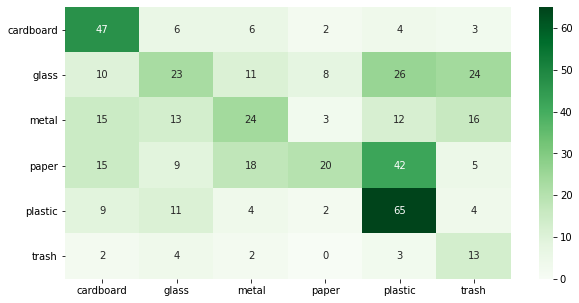

In [14]:
plt.figure(figsize = (10, 5))
sns.heatmap(matrizConfusion, cmap="Greens", annot=True, 
            xticklabels = ["cardboard","glass","metal","paper","plastic","trash"],
            yticklabels = ["cardboard","glass","metal","paper","plastic","trash"]);
plt.savefig("conf matrix")

In [15]:
print('Se han predicho correctamente',aciertos,'imágenes')
print('Se han predicho erróneamente',errores,'imágenes\n')
porcentajeAcierto = (aciertos/totales)*100
porcentajeError = (errores/totales)*100
print('El porcentaje de acierto ha sido del:',round(porcentajeAcierto,2),'%')
print('El porcentaje de error ha sido del:',round(porcentajeError,2),'%')

Se han predicho correctamente 192 imágenes
Se han predicho erróneamente 289 imágenes

El porcentaje de acierto ha sido del: 39.92 %
El porcentaje de error ha sido del: 60.08 %


El resultado de las imágenes correctamente predichas es igual a la suma de la diagonal de nuestra matriz de confusión.
Respecto a la figura de la matriz, los colores más oscuros de la diagonal son los que representan los aciertos de una categoría.

### 2) Elige 5 imágenes de diferentes residuos que no hayas usado ni para entrenar ni para validar el modelo y clasifícalas. Utiliza el modelo que consideres que clasifica mejor obtenido en el punto anterior. Indica con qué error ha funcionado el clasificador.

Utilizamos el 5% que habíamos guardado del conjunto test para este apartado.

In [16]:
#Predecir los valores para el conjunto de datos en X_val y compararlos con y_val
predicciones = gnb.predict(X_val)

#Comprobando fiabilidad del modelo
aciertos = 0;
errores = 0;
totales = len(predicciones)
i = 0
for valorPredicho in predicciones:
    #Pasamos las clases a sus valores nominales
    print('Se ha predicho que la imagen es:\033[1m', clases[valorPredicho], '\033[0m Deberia ser:\033[1m', clases[y_test[i]], '\033[0m')
    if valorPredicho == y_test[i]:
        print('\033[92mACIERTO!\033[0m')
        aciertos = aciertos+1
    else:
        print('\033[91mERROR\033[0m')
        errores = errores+1
    i = i+1

Se ha predicho que la imagen es: plastic  Deberia ser: metal 
ERROR
Se ha predicho que la imagen es: cardboard  Deberia ser: glass 
ERROR
Se ha predicho que la imagen es: paper  Deberia ser: plastic 
ERROR
Se ha predicho que la imagen es: glass  Deberia ser: metal 
ERROR
Se ha predicho que la imagen es: glass  Deberia ser: metal 
ERROR
Se ha predicho que la imagen es: plastic  Deberia ser: plastic 
ACIERTO!
Se ha predicho que la imagen es: metal  Deberia ser: metal 
ACIERTO!
Se ha predicho que la imagen es: cardboard  Deberia ser: paper 
ERROR
Se ha predicho que la imagen es: metal  Deberia ser: cardboard 
ERROR
Se ha predicho que la imagen es: glass  Deberia ser: paper 
ERROR
Se ha predicho que la imagen es: plastic  Deberia ser: plastic 
ACIERTO!
Se ha predicho que la imagen es: plastic  Deberia ser: plastic 
ACIERTO!
Se ha predicho que la imagen es: metal  Deberia ser: glass 
ERROR
Se ha predicho que la imagen es: plastic  Deberia ser: paper 
ERROR
Se ha predicho que la imagen es: p

In [17]:
print('Se han predicho correctamente',aciertos,'imágenes')
print('Se han predicho erróneamente',errores,'imágenes\n')
porcentajeAcierto = (aciertos/totales)*100
porcentajeError = (errores/totales)*100
print('\033[92mEl porcentaje de acierto ha sido del:',round(porcentajeAcierto,2),'%\033[0m')
print('\033[91mEl porcentaje de error ha sido del:',round(porcentajeError,2),'%\033[0m')

Se han predicho correctamente 6 imágenes
Se han predicho erróneamente 19 imágenes

El porcentaje de acierto ha sido del: 24.0 %
El porcentaje de error ha sido del: 76.0 %


## Conclusión

El porcentaje de error tan alto es debido a la falta de igualdad entre los elementos de las clases. Es decir, encontramos categorías que presentan muchos más datos a analizar, como por ejemplo <i>paper</i> o <i>glass</i>. En cambio, hay categorías como <i>trash</i> que presentan un bajo índice de registros. La diferencia de istancias llega a ser de 594 el máximo respecto a 137 el mínimo, aproximadamente 3 veces menos.
Para poder subsanar este problema podríamos tratar de igualar los registros en todos los directorios.